In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_neuro_diagnoses = pd.read_csv("Data/Neuro_Diagnosis.csv")

In [3]:
env = DiagnosisEnv(df_symptoms, df_exams, df_neuro_diagnoses)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=2000)

C:\Users\jerem\Project_Hospital\Agent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return (torch.tensor(state, dtype=torch.float32),


In [4]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

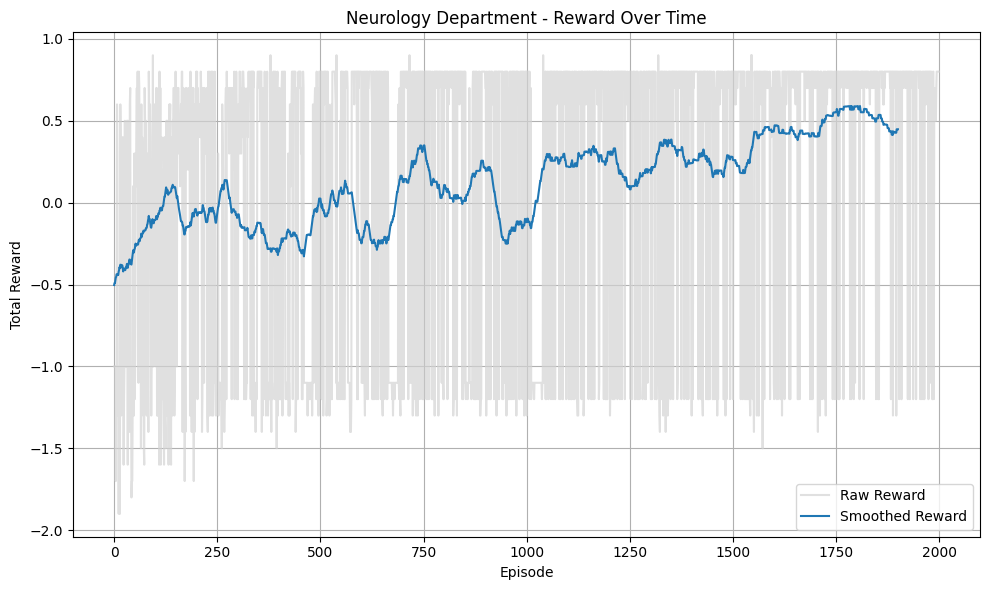

In [6]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Neurology Department - Reward Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

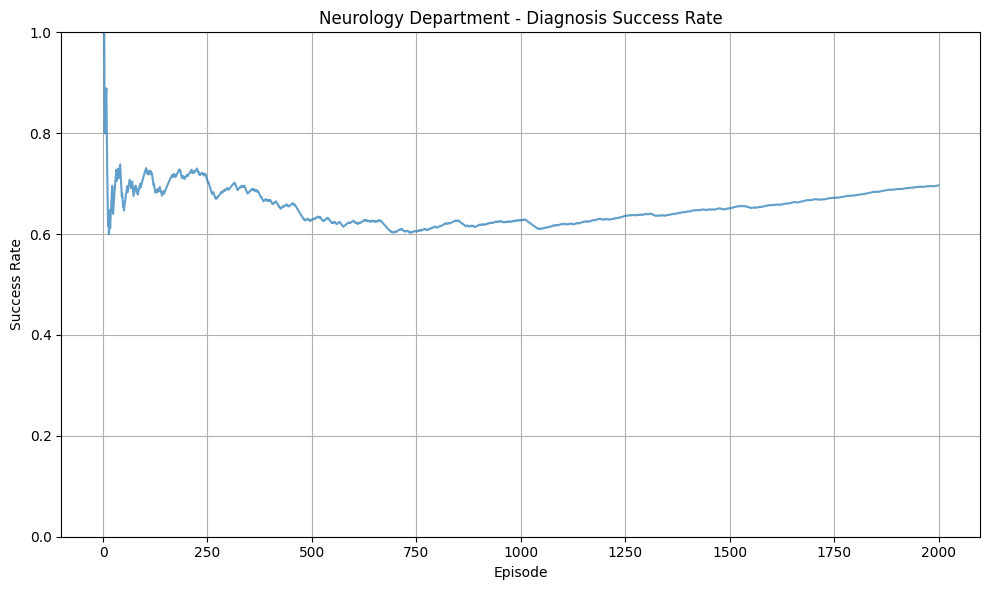

In [7]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Neurology Department - Diagnosis Success Rate")
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()

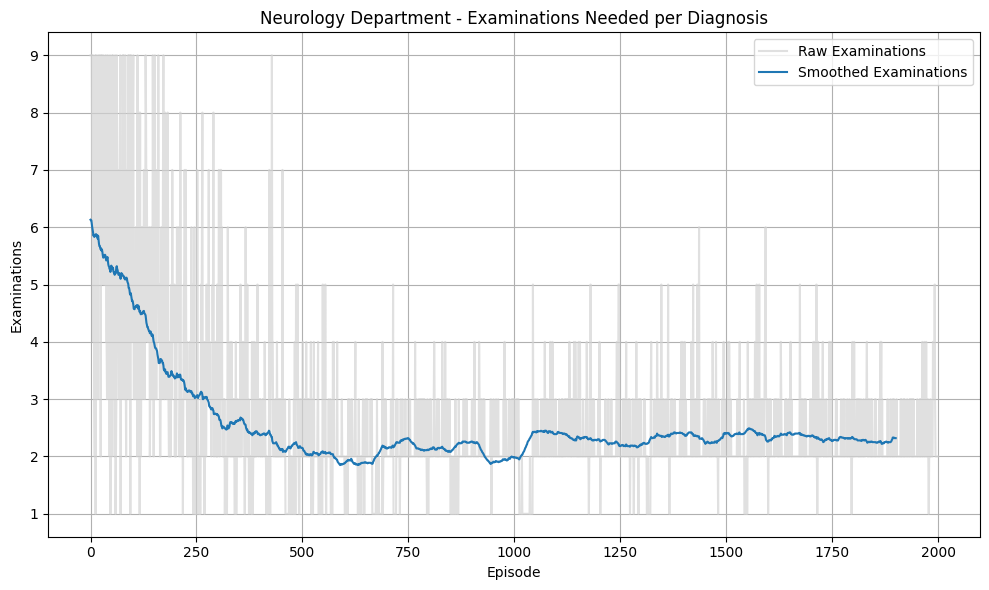

In [9]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode")
plt.ylabel("Examinations")
plt.title("Neurology Department - Examinations Needed per Diagnosis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_neuro_diagnoses)
    print("Neurology Department, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_neuro_diagnoses.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("Neurology Department - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [13]:
test_agent(env, agent, num_patients=10)

Neurology Department, Number of possible Diagnosis: 29
Angle-closure glaucoma - Accuracy over 10 patients: 1.0
Blepharitis - Accuracy over 10 patients: 1.0
Botulism - Accuracy over 10 patients: 1.0
Cerebral contusion - Accuracy over 10 patients: 1.0
Cipd - Accuracy over 10 patients: 1.0
Cluster headache - Accuracy over 10 patients: 0.9
Concussion - Accuracy over 10 patients: 1.0
Conjunctivitis (allergic) - Accuracy over 10 patients: 1.0
Conjunctivitis (bacterial) - Accuracy over 10 patients: 0.9
Corneal abrasion - Accuracy over 10 patients: 0.8
Crvo - Accuracy over 10 patients: 0.1
Diffuse axonal injury - Accuracy over 10 patients: 0.9
Encephalitis - Accuracy over 10 patients: 1.0
Guillain-barre syndrome - Accuracy over 10 patients: 1.0
Hypertensive retinopathy - Accuracy over 10 patients: 0.5
Keratitis - bacterial - Accuracy over 10 patients: 0.0
Migraine - Accuracy over 10 patients: 1.0
Neuromyelitis optica - Accuracy over 10 patients: 0.8
Open-angle glaucoma - Accuracy over 10 patie

In [14]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_neuro_diagnoses.index[df_neuro_diagnoses["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print(f"\nGuessed Diagnosis: {info['guess'].capitalize()}")
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(f"{diagnosis.capitalize()}: Accuracy over {num_patients} patients: {accuracy:.2f}")

In [15]:
test_diagnosis(env, agent, "crvo", 5)


PATIENT 1
TRUE DIAGNOSIS: crvo
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'loss of vision', 'vein occlusion']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision', 'loss of vision']
Step 2
Examination taken: sweat chloride test
Symptoms uncovered so far: ['blurred vision', 'loss of vision']

Guessed Diagnosis: Crvo

PATIENT 2
TRUE DIAGNOSIS: crvo
TRUE SYMPTOMS (Generated for this patient): ['hypertension', 'loss of vision', 'vein occlusion']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['loss of vision']
Step 2
Examination taken: sweat chloride test
Symptoms uncovered so far: ['loss of vision']

Guessed Diagnosis: Corneal abrasion

PATIENT 3
TRUE DIAGNOSIS: crvo
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'ocular hypertension', 'vein occlusion']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision']
Step 2
Examination taken: biopsy testing
Symptoms uncovered so far: ['blu

In [17]:
test_diagnosis(env, agent, "keratitis - bacterial", 5)


PATIENT 1
TRUE DIAGNOSIS: keratitis - bacterial
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'eye pain', 'red eye', 'watery eyes', 'p. aeruginosa']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'red eye', 'watery eyes']
Step 2
Examination taken: spirometry
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'red eye', 'watery eyes']

Guessed Diagnosis: Conjunctivitis (bacterial)

PATIENT 2
TRUE DIAGNOSIS: keratitis - bacterial
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'itchy eyes', 'red eye', 'watery eyes', 'p. aeruginosa']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['eye pain', 'itchy eyes', 'red eye', 'watery eyes']
Step 2
Examination taken: neck palpation
Symptoms uncovered so far: ['eye pain', 'itchy eyes', 'red eye', 'watery eyes']

Guessed Diagnosis: Blepharitis

PATIENT 3
TRUE DIAGNOSIS: keratitis - bacterial
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'itch

In [18]:
test_diagnosis(env, agent, "uveitis", 5)


PATIENT 1
TRUE DIAGNOSIS: uveitis
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'eye pain', 'photophobia', 'retina scarring']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'photophobia']
Step 2
Examination taken: gonioscopy
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'photophobia']

Guessed Diagnosis: Angle-closure glaucoma

PATIENT 2
TRUE DIAGNOSIS: uveitis
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'eye pain', 'photophobia', 'red eye', 'retina scarring']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'photophobia', 'red eye']
Step 2
Examination taken: gonioscopy
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'photophobia', 'red eye']

Guessed Diagnosis: Conjunctivitis (bacterial)

PATIENT 3
TRUE DIAGNOSIS: uveitis
TRUE SYMPTOMS (Generated for this patient): ['photophobia', 'red eye', 'retina scarring']

Step 1
Examination take